In [2]:
import os
import tensorflow as tf
import wfdb
import numpy as np
from tqdm import tqdm

# Define the path to your dataset directory
DATA_DIR = "C:/Users/M2-Winterfell/Downloads/electrocardiography-dataset-1.0.3/records500/00000"

# Function to load and extract Lead I and Lead II from a single record
def load_ecg_leads(file_path):
    try:
        # Load the record using wfdb (the file_path should be without extension)
        record = wfdb.rdrecord(file_path)
        
        # Extract Lead I and Lead II (assuming they are the first two leads)
        lead_I = record.p_signal[:, 0]  # Lead I
        lead_II = record.p_signal[:, 1]  # Lead II
        
        return lead_I, lead_II
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None

# Function to load only the first 1000 ECG records
def load_first_n_ecg_data(data_dir, n=1000):
    all_lead_I = []
    all_lead_II = []
    
    count = 0  # To keep track of the number of records loaded
    
    # Traverse through all subdirectories in records500
    for root, dirs, files in os.walk(data_dir):
        for file in tqdm(files, desc="Loading ECG files"):
            if file.endswith("_hr.dat"):  # Look for files with the _hr suffix
                # Stop loading after reaching the first n records
                if count >= n:
                    break
                
                # Construct the base filename (removing the '_hr.dat' extension)
                base_filename = file.replace("_hr.dat", "_hr")
                record_path = os.path.join(root, base_filename)
                
                # Load Lead I and Lead II
                lead_I, lead_II = load_ecg_leads(record_path)
                
                if lead_I is not None and lead_II is not None:
                    all_lead_I.append(lead_I)
                    all_lead_II.append(lead_II)
                    count += 1
                else:
                    print(f"Skipping record: {base_filename}")

        if count >= n:  # Break the outer loop as well
            break
    
    # Convert lists to NumPy arrays if data was loaded
    if all_lead_I and all_lead_II:
        all_lead_I = np.array(all_lead_I)  # Shape: (num_records, samples_per_record)
        all_lead_II = np.array(all_lead_II)  # Shape: (num_records, samples_per_record)
    else:
        all_lead_I = np.array([])  # Empty array if no data
        all_lead_II = np.array([])  # Empty array if no data
    
    return all_lead_I, all_lead_II

# Load only the first 1000 ECG records from records500
lead_I_data, lead_II_data = load_first_n_ecg_data(DATA_DIR, n=1000)

# Check if data was loaded successfully
if lead_I_data.size > 0 and lead_II_data.size > 0:
    print(f"Total records loaded: {lead_I_data.shape[0]}")
    print(f"Each record has {lead_I_data.shape[1]} samples per lead.")
    
    # Check shapes
    print("Lead I data shape:", lead_I_data.shape)
    print("Lead II data shape:", lead_II_data.shape)
else:
    print("No data was loaded.")


Loading ECG files: 100%|██████████| 1974/1974 [00:03<00:00, 496.53it/s]

Total records loaded: 987
Each record has 5000 samples per lead.
Lead I data shape: (987, 5000)
Lead II data shape: (987, 5000)


Normalize ECG signals to ensure data ranges are consistent, which help stabilizing the training of neural networks

In [3]:
from sklearn.preprocessing import MinMaxScaler
# Initialize the scaler for normalization
scaler = MinMaxScaler(feature_range=(-1, 1))  # ECG signals can have negative values

# Normalize Lead I and Lead II data
if lead_I_data.size > 0 and lead_II_data.size > 0:
    lead_I_scaled = scaler.fit_transform(lead_I_data)

    # Normalize Lead II data using the same scaler
    lead_II_scaled = scaler.transform(lead_II_data)

    # Verify normalization
    print("Lead I scaled data range:", lead_I_scaled.min(), lead_I_scaled.max())
    print("Lead II scaled data range:", lead_II_scaled.min(), lead_II_scaled.max())
else:
    print("Skipping normalization since no data was loaded.")

Lead I scaled data range: -1.0 1.0000000000000004
Lead II scaled data range: -3.4331450094161955 3.042488619119878


Conv1D + LSTM Generator

In [4]:
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model

def build_cnn_generator(input_shape=(5000, 1)):
    inputs = Input(shape=input_shape)
    
    # First Convolutional Block
    x = Conv1D(32, kernel_size=3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(32, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    
    # Second Convolutional Block
    x = Conv1D(64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    
    # Third Convolutional Block
    x = Conv1D(128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    
    # Final output layer to reconstruct the 1D signal
    outputs = Conv1D(1, kernel_size=3, padding='same', activation='tanh')(x)
    
    generator_model = Model(inputs, outputs)
    return generator_model

Conv1D + LSTM Discriminator

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dropout, Flatten, Dense

def build_cnn_discriminator(input_shape=(5000, 1)):
    model = Sequential()
    
    # First Convolutional Block
    model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    
    # Second Convolutional Block
    model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    
    # Third Convolutional Block
    model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    
    # Classification head
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

1. The discriminator should be frozen during the generator's training
2. The goal here is to only train the generator to fool the discriminator, while keeping discriminator fixed
3. If don't freeze, both generator and discriminator would adjust simultaneously and generator would not improve effectively

Full Training

Epoch [1/20] - D Loss: 1.1959, G Loss: 3.3079
Epoch [2/20] - D Loss: 0.7158, G Loss: 2.3329
1/1 [==============================] - 1s 590ms/step


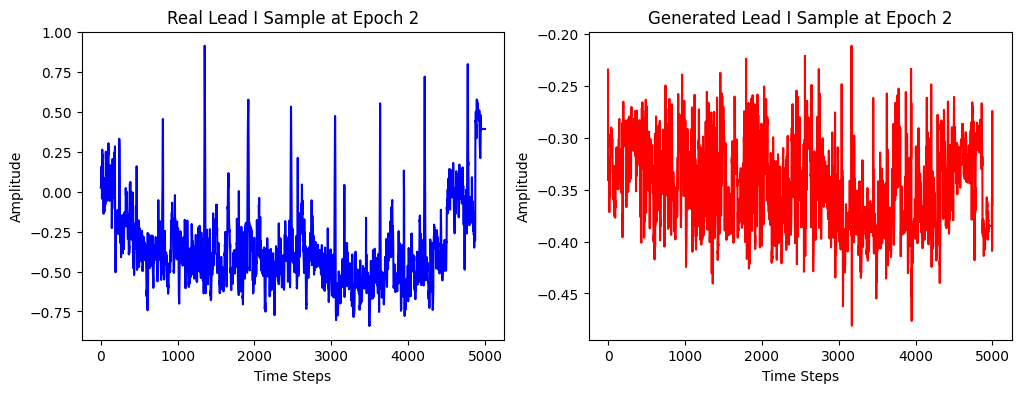

Epoch [3/20] - D Loss: 0.7061, G Loss: 2.3051
Epoch [4/20] - D Loss: 0.7042, G Loss: 2.2857
1/1 [==============================] - 0s 29ms/step


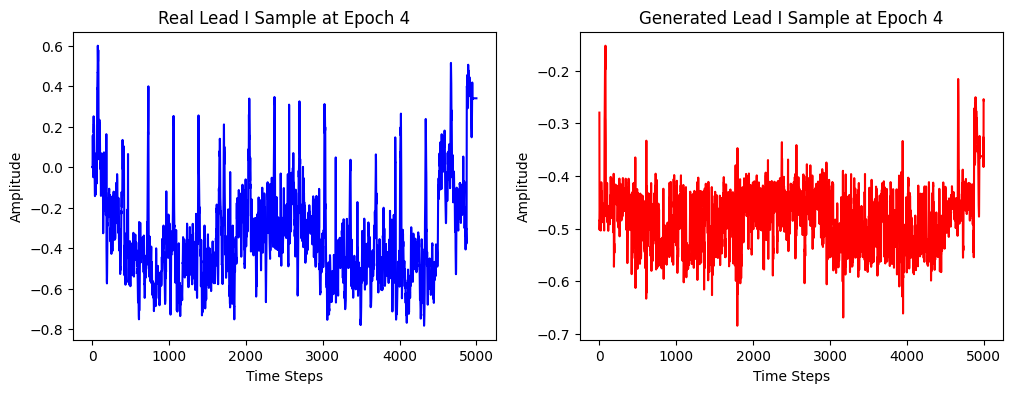

Epoch [5/20] - D Loss: 0.6962, G Loss: 2.2487
Epoch [6/20] - D Loss: 0.6971, G Loss: 2.2041
1/1 [==============================] - 0s 27ms/step


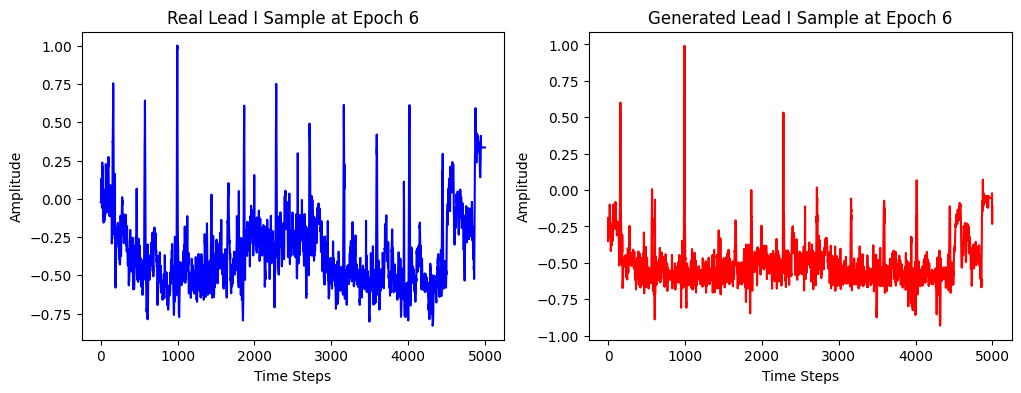

Epoch [7/20] - D Loss: 0.6937, G Loss: 2.1725
Epoch [8/20] - D Loss: 0.6915, G Loss: 2.1906
1/1 [==============================] - 0s 28ms/step


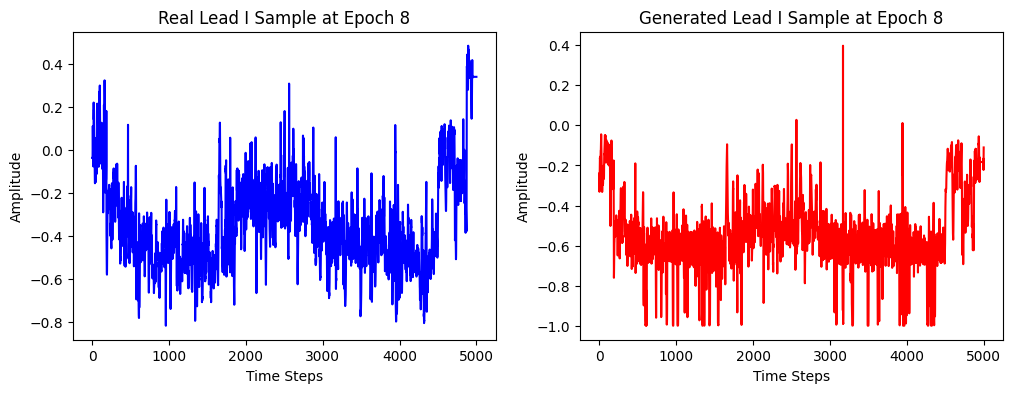

Epoch [9/20] - D Loss: 0.6960, G Loss: 2.1675
Epoch [10/20] - D Loss: 0.6940, G Loss: 2.1717
1/1 [==============================] - 0s 26ms/step


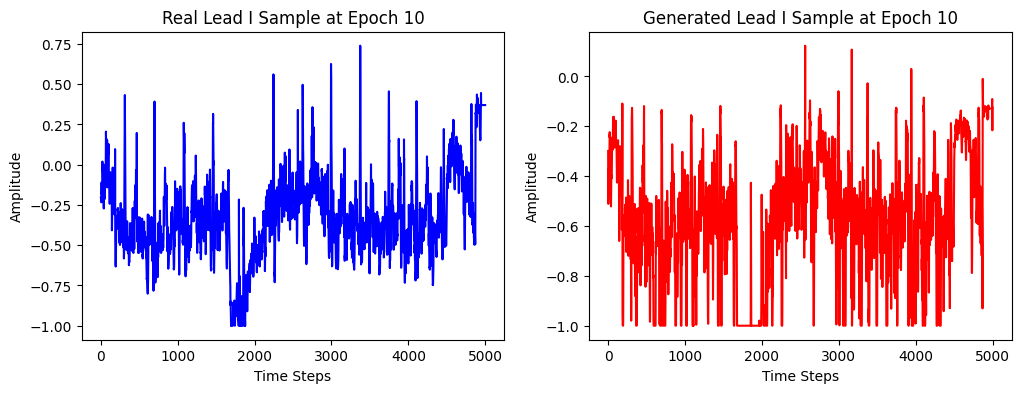

Epoch [11/20] - D Loss: 0.6995, G Loss: 2.1877
Epoch [12/20] - D Loss: 0.6979, G Loss: 2.2518
1/1 [==============================] - 0s 25ms/step


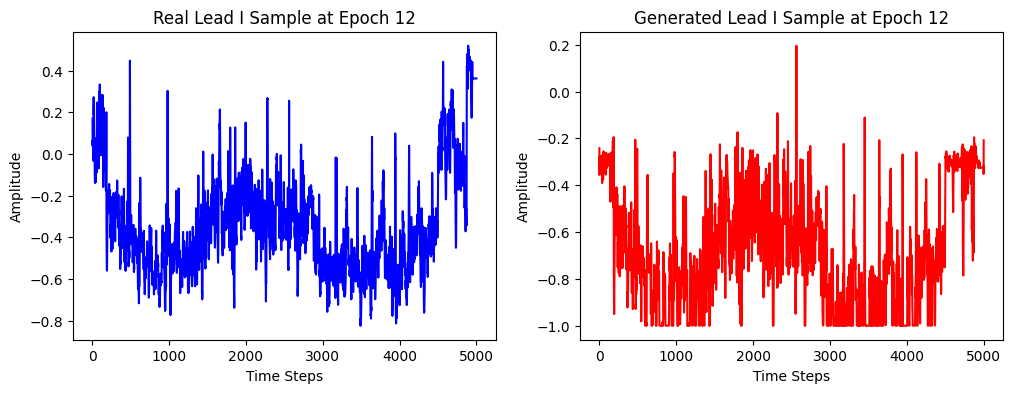

Epoch [13/20] - D Loss: 0.6929, G Loss: 2.2997
Epoch [14/20] - D Loss: 0.6919, G Loss: 2.2109
1/1 [==============================] - 0s 24ms/step


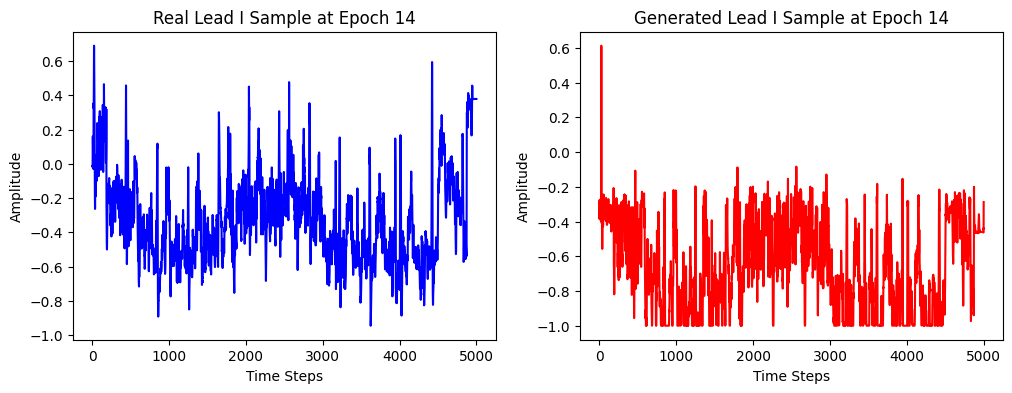

Epoch [15/20] - D Loss: 0.6956, G Loss: 2.2342
Epoch [16/20] - D Loss: 0.6923, G Loss: 2.1904
1/1 [==============================] - 0s 24ms/step


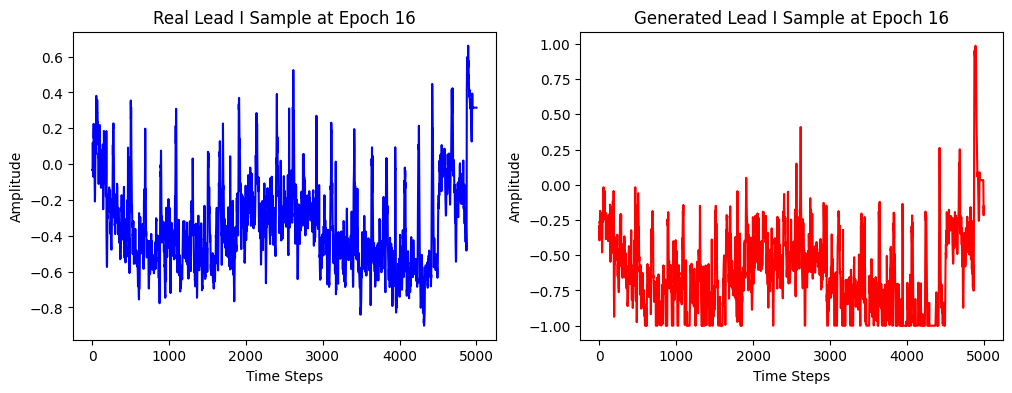

Epoch [17/20] - D Loss: 0.6948, G Loss: 2.1901
Epoch [18/20] - D Loss: 0.6938, G Loss: 2.1666
1/1 [==============================] - 0s 24ms/step


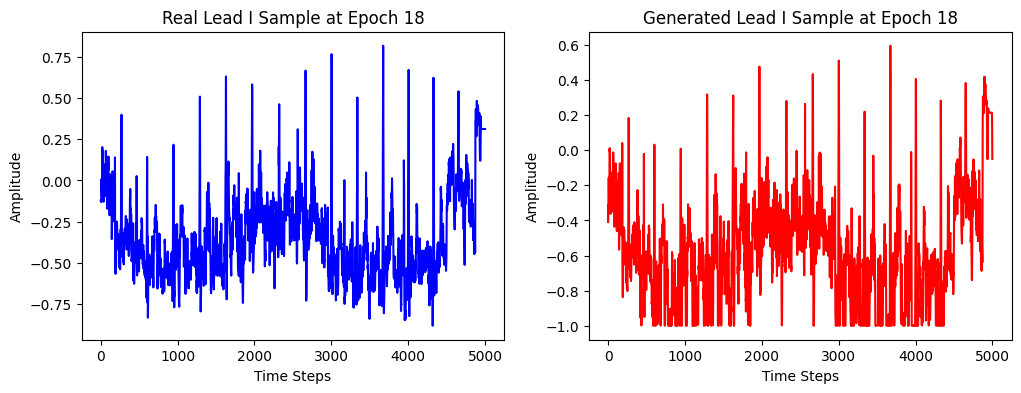

Epoch [19/20] - D Loss: 0.6946, G Loss: 2.1538
Epoch [20/20] - D Loss: 0.6929, G Loss: 2.1257
1/1 [==============================] - 0s 25ms/step


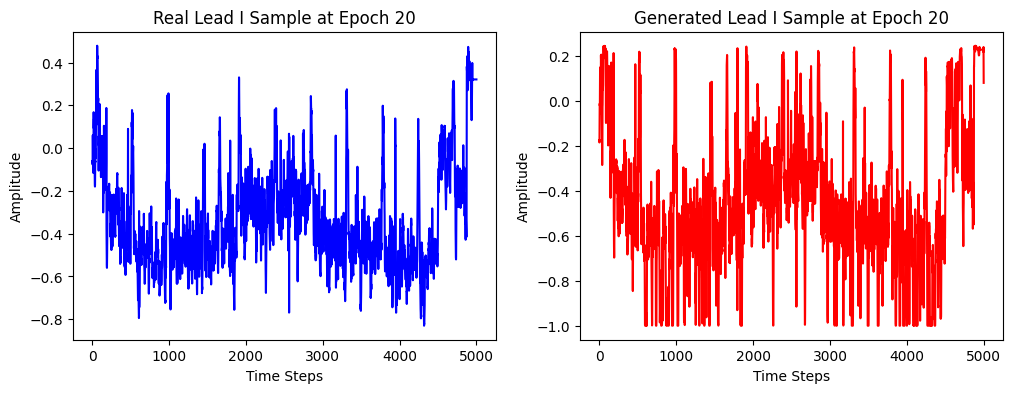

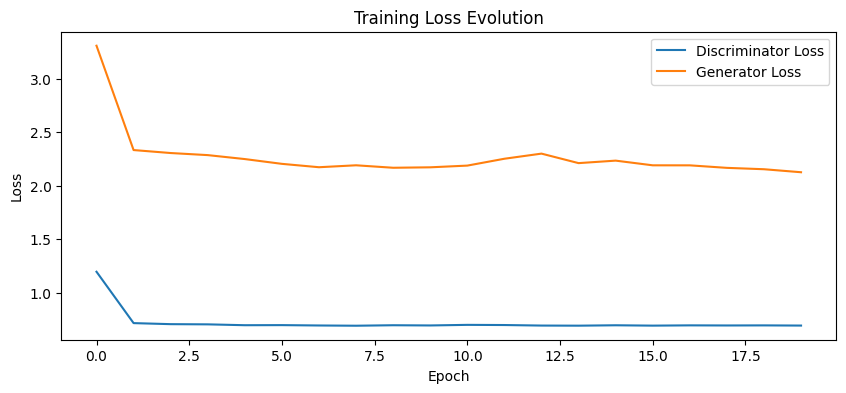

Generator model saved as 'generator_lead_I.h5'.


c:\Users\M2-Winterfell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError

# Initialize models (assuming build_cnn_generator and build_cnn_discriminator are defined)
generator = build_cnn_generator(input_shape=(5000, 1))
discriminator = build_cnn_discriminator(input_shape=(5000, 1))

# Optimizers
g_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
d_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

# Loss functions
bce_loss = BinaryCrossentropy(from_logits=False)
mse_loss = MeanSquaredError()

# Training parameters
epochs = 50
batch_size = 32
real_label = 0.9  # Soft label for real data
fake_label = 0.1  # Soft label for fake data

# Reshape the data to match the input requirements (add a channel dimension)
lead_I_segments = np.expand_dims(lead_I_scaled, axis=-1)  # Shape: (num_records, samples_per_record, 1)

# Dictionary to store training history
history = {'d_loss': [], 'g_loss': []}

# Training loop
for epoch in range(epochs):
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0
    num_batches = 0
    
    for i in range(0, len(lead_I_segments), batch_size):
        input_batch = lead_I_segments[i:i + batch_size]
        real_lead_I_batch = lead_I_segments[i:i + batch_size]
        batch_size_actual = input_batch.shape[0]

        # Train Discriminator
        with tf.GradientTape() as d_tape:
            fake_lead_I = generator(input_batch, training=True)
            real_preds = discriminator(real_lead_I_batch, training=True)
            fake_preds = discriminator(fake_lead_I, training=True)
            
            real_targets = tf.ones((batch_size_actual, 1)) * real_label
            fake_targets = tf.ones((batch_size_actual, 1)) * fake_label
            
            d_loss_real = bce_loss(real_targets, real_preds)
            d_loss_fake = bce_loss(fake_targets, fake_preds)
            d_loss = d_loss_real + d_loss_fake
        
        d_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
        d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

        # Train Generator
        with tf.GradientTape() as g_tape:
            fake_lead_I = generator(input_batch, training=True)
            fake_preds = discriminator(fake_lead_I, training=True)

            g_adv_loss = bce_loss(real_targets, fake_preds)
            g_recon_loss = mse_loss(real_lead_I_batch, fake_lead_I)
            g_loss = g_adv_loss + g_recon_loss
        
        g_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
        g_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))

        epoch_d_loss += d_loss
        epoch_g_loss += g_loss
        num_batches += 1
    
    avg_d_loss = epoch_d_loss / num_batches
    avg_g_loss = epoch_g_loss / num_batches
    history['d_loss'].append(avg_d_loss.numpy())
    history['g_loss'].append(avg_g_loss.numpy())

    print(f"Epoch [{epoch + 1}/{epochs}] - D Loss: {avg_d_loss.numpy():.4f}, G Loss: {avg_g_loss.numpy():.4f}")

    # Visualization every 5 epochs
    if (epoch + 1) % 5 == 0:
        random_index = np.random.randint(0, len(lead_I_segments))
        real_sample = lead_I_segments[random_index]  
        input_sample = np.expand_dims(real_sample, axis=0)
        generated_sample = generator.predict(input_sample)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(real_sample[:, 0], color='blue')
        plt.title(f"Real Lead I Sample at Epoch {epoch + 1}")
        plt.xlabel("Time Steps")
        plt.ylabel("Amplitude")

        plt.subplot(1, 2, 2)
        plt.plot(generated_sample[0, :, 0], color='red')
        plt.title(f"Generated Lead I Sample at Epoch {epoch + 1}")
        plt.xlabel("Time Steps")
        plt.ylabel("Amplitude")

        plt.show()

# Plot training history
plt.figure(figsize=(10, 4))
plt.plot(history['d_loss'], label='Discriminator Loss')
plt.plot(history['g_loss'], label='Generator Loss')
plt.title("Training Loss Evolution")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# --------------------------
# Generate 10 Fake ECG Signals
# --------------------------
save_path = "C:/Users/M2-Winterfell/Downloads/Dissertation/results"
os.makedirs(save_path, exist_ok=True)

for i in range(10):
    # Select a random real ECG sample as input
    random_index = np.random.randint(0, len(lead_I_segments))
    real_sample = lead_I_segments[random_index]  
    input_sample = np.expand_dims(real_sample, axis=0)

    # Generate fake ECG
    generated_sample = generator.predict(input_sample)[0, :, 0]  # Shape: (5000,)

    # Plot the generated ECG
    plt.figure(figsize=(12, 4))
    plt.plot(generated_sample, color='red')
    plt.title(f"Generated ECG Sample {i+1}")
    plt.xlabel("Time Steps")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()

    # Save as .asc file
    file_path = os.path.join(save_path, f"generated_ecg_{i+1}.asc")
    np.savetxt(file_path, generated_sample, fmt="%.6f")
    print(f"Generated ECG {i+1} saved to: {file_path}")

print("All generated ECG signals have been saved successfully.")
